<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [11]:
# from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding

import matplotlib.pyplot as plt

In [27]:
import pandas as pd
import numpy as np

df = pd.read_csv('sample.csv')


In [29]:
df.head()
df['y'] = np.random.randint(0,2,size=len(df))
df.head()
df.shape

(52623, 6)

In [184]:
sample_df = df.sample(n=10000)

In [185]:
sample_df['same'] = sample_df['same'].astype(int)
sample_df['same'].mean()

0.5286

In [ ]:
max_length = sample_df.pair.apply(lambda x: len(x.split())).max()
max_length = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sample_df['pair'])
sample_df['tokenized_text_1'] = tokenizer.texts_to_sequences(sample_df['text_1'])
sample_df['tokenized_text_2'] = tokenizer.texts_to_sequences(sample_df['text_2'])
sample_df['tokenized_text_1'] = list(pad_sequences(sample_df['tokenized_text_1'], maxlen = max_length, padding='post'))
sample_df['tokenized_text_2'] = list(pad_sequences(sample_df['tokenized_text_2'], maxlen = max_length, padding='post'))

# vocab_size = max(max([max(sublist) for sublist in df['tokenized_text_1'].values])+1 , max([max(sublist) for sublist in df['tokenized_text_2'].values])+1 )
vocab_size = len(tokenizer.word_index.items())+1
vocab_size

In [49]:
import numpy as np
embeddings_index = dict()
f = open('../../glove/glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [166]:
len(tokenizer.word_index.items()),vocab_size
vocab_size = len(tokenizer.word_index.items())+1


In [167]:
embedding_matrix = np.zeros((vocab_size, 100))
print(len(tokenizer.word_index.items()))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix

70573


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve


X_train, X_test, y_train, y_test = train_test_split(sample_df[['tokenized_text_1','tokenized_text_2']], sample_df['same'], random_state=1)

In [77]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM


model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length = max_length))
model.add(LSTM(64, return_sequences=True,
              dropout=0.3, recurrent_dropout=0.3))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

batch_size = 8
history = model.fit(np.stack(X_train['tokenized_text_1'], axis=0),
          y_train,
          epochs = 30,
          batch_size=batch_size, 
          validation_data = (np.stack(X_test['tokenized_text_1'],axis=0), y_test),
          verbose = 1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 100)          1743900   
_________________________________________________________________
lstm_17 (LSTM)               (None, 100, 64)           42240     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)              

c:\users\212778050\pycharmprojects\predict-sr-based-on-syslog\deploy_model\env_deployment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 75 samples, validate on 25 samples
Epoch 1/30
75/75 [==============================] - 4s 50ms/step - loss: 0.7031 - accuracy: 0.5467 - val_loss: 0.6878 - val_accuracy: 0.5600
Epoch 2/30
75/75 [==============================] - 3s 42ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6874 - val_accuracy: 0.7600
Epoch 3/30
75/75 [==============================] - 3s 47ms/step - loss: 0.6952 - accuracy: 0.5333 - val_loss: 0.6881 - val_accuracy: 0.5200
Epoch 4/30
75/75 [==============================] - 3s 42ms/step - loss: 0.7133 - accuracy: 0.5333 - val_loss: 0.6888 - val_accuracy: 0.5200
Epoch 5/30
75/75 [==============================] - 3s 46ms/step - loss: 0.6803 - accuracy: 0.6400 - val_loss: 0.6918 - val_accuracy: 0.5200
Epoch 6/30
75/75 [==============================] - 3s 41ms/step - loss: 0.6853 - accuracy: 0.5333 - val_loss: 0.7035 - val_accuracy: 0.5200
Epoch 7/30
75/75 [==============================] - 3s 44ms/step - loss: 0.7137 - accuracy: 0.4933 - val_loss:

In [181]:
from keras.models import Sequential, Model 
from keras.layers import Dense, Embedding, Dropout, LSTM, Concatenate , Reshape , Activation , Input
from tensorflow.keras.layers import Subtract ,Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers import LeakyReLU



# create a eneric embedding layer model 
def create_model(vocab_size,max_length,embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length = max_length))
    model.add(LSTM(64, 
                   return_sequences=True,
                   dropout=0.3,
                   recurrent_dropout=0.3))
    model.add(GlobalMaxPool1D())
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    return model

t1 = create_model(vocab_size,max_length,embedding_matrix)
t2 = create_model(vocab_size,max_length,embedding_matrix)

combinedInput = concatenate([t1.output, t1.output])

x = Dense(16)(combinedInput)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[t1.input, t2.input], outputs=x)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics = ['accuracy'])


# train the model
print("[INFO] training model...")
history = model.fit(
    x=[np.stack(X_train['tokenized_text_1'], axis=0),
       np.stack(X_train['tokenized_text_2'], axis=0)],
    y=y_train,
    validation_data=([np.stack(X_test['tokenized_text_1'], axis=0),
                       np.stack(X_test['tokenized_text_2'], axis=0)], y_test),
    epochs=2,
    batch_size=256)





[INFO] training model...
Train on 750 samples, validate on 250 samples
Epoch 1/2
750/750 [==============================] - 38s 50ms/step - loss: 0.7191 - accuracy: 0.4760 - val_loss: 0.6955 - val_accuracy: 0.4760
Epoch 2/2
750/750 [==============================] - 33s 44ms/step - loss: 0.6972 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4880


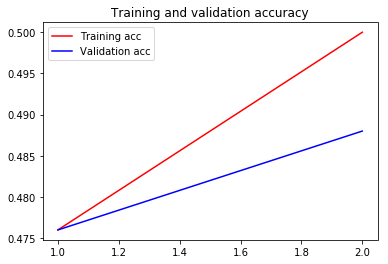

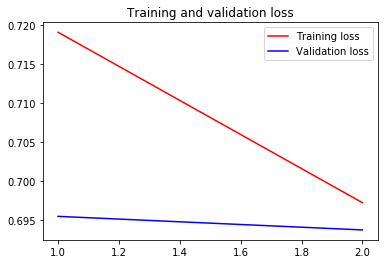

In [182]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [183]:
history.history

{'val_loss': [0.6954734325408936, 0.6937342882156372],
 'val_accuracy': [0.47600001096725464, 0.4880000054836273],
 'loss': [0.7191058629353841, 0.6972303125063578],
 'accuracy': [0.476, 0.5]}